<a href="https://colab.research.google.com/github/zenikigai/Tugas_akhir1/blob/main/Proyek_Akhir_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama Lengkap: Astawan Zen
Subject: Proyek Akhir : Klasifikasi Gambar

In [1]:
# Dataset sudah saya ikut sertakan pada file ini.
# Uncomment 2 baris di bawah jika ingin mengunduh ulang dataset.
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
!unzip rockpaperscissors.zip

Streaming output truncated to the last 5000 lines.
  inflating: rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._0CSaM2vL2cWX6

In [34]:
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

In [3]:
# Mendefinisikan path dataset
base_dir = 'rockpaperscissors'
img_dir = os.path.join(base_dir, 'rps-cv-images')

In [4]:
# Membuat direktori untuk training dan validation set
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [5]:
# Membagi dataset menjadi train set dan validation set
for class_label in os.listdir(img_dir):
    class_path = os.path.join(img_dir, class_label)

    # Memastikan bahwa yang dibaca adalah direktori, bukan file
    if os.path.isdir(class_path):
        # Membagi setiap kelas menjadi training dan validation
        train_images, val_images = train_test_split(os.listdir(class_path), test_size=0.4, random_state=42)

        # Membuat direktori untuk setiap kelas di dalam train dan val
        os.makedirs(os.path.join(train_dir, class_label), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_label), exist_ok=True)

        # Memindahkan gambar ke dalam direktori yang sesuai
        for img in train_images:
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(train_dir, class_label, img)
            os.rename(src_path, dest_path)

        for img in val_images:
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(val_dir, class_label, img)
            os.rename(src_path, dest_path)


In [6]:
# Membuat ImageDataGenerator dengan augmentasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Memuat data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Memuat data validation
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


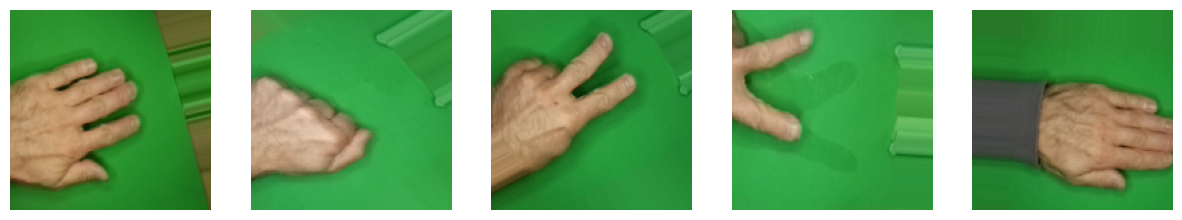

In [39]:
# Menampilkan contoh gambar setelah augmentasi
augmented_images = next(train_generator)
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(augmented_images[0][i])
    axs[i].axis('off')
plt.show()

In [10]:
# Definisi model sequential
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Penambahan dropout layer
    Dense(3, activation='softmax')  # Sesuaikan dengan jumlah kelas
])

In [35]:
# Kompilasi model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Membuat folder untuk menyimpan checkpoint
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

In [37]:
# Callback ModelCheckpoint
checkpoint_filepath = os.path.join(checkpoint_dir, 'my_model_checkpoint.h5')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [38]:
# Melatih model (estimasi waktu 20m 33s)
my_model = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    verbose=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
41/41 [==============================] - 164s 4s/step - loss: 0.1710 - accuracy: 0.9512 - val_loss: 0.0968 - val_accuracy: 0.9737
Epoch 2/5
41/41 [==============================] - 164s 4s/step - loss: 0.1483 - accuracy: 0.9550 - val_loss: 0.0710 - val_accuracy: 0.9817
Epoch 3/5
41/41 [==============================] - 162s 4s/step - loss: 0.1353 - accuracy: 0.9558 - val_loss: 0.0881 - val_accuracy: 0.9772
Epoch 4/5
41/41 [==============================] - 181s 4s/step - loss: 0.1241 - accuracy: 0.9588 - val_loss: 0.0751 - val_accuracy: 0.9783
Epoch 5/5
41/41 [==============================] - 177s 4s/step - loss: 0.1101 - accuracy: 0.9688 - val_loss: 0.0707 - val_accuracy: 0.9806


In [40]:
# Memuat bobot terbaik
model.load_weights(checkpoint_filepath)

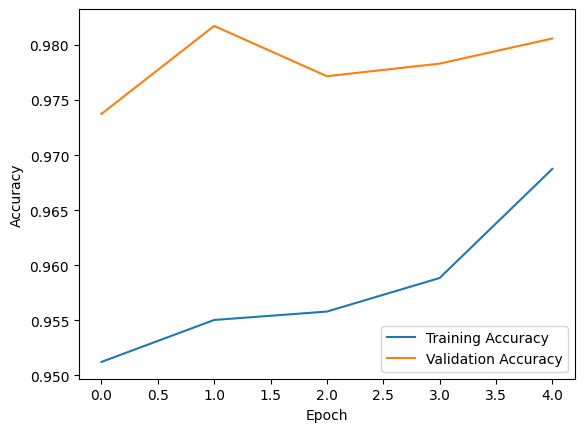

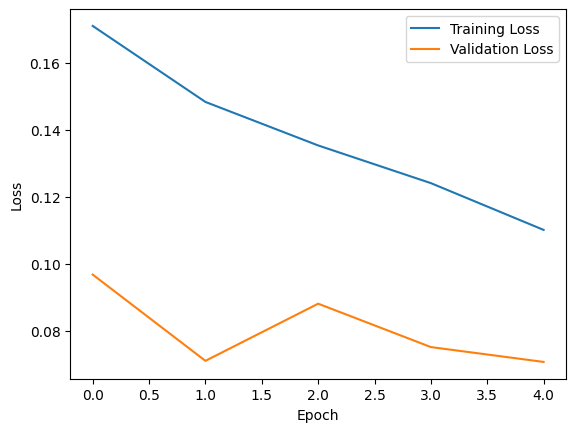

In [41]:
# Menampilkan grafik akurasi
plt.plot(my_model.history['accuracy'], label='Training Accuracy')
plt.plot(my_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Menampilkan grafik loss
plt.plot(my_model.history['loss'], label='Training Loss')
plt.plot(my_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Saving 04l5I8TqdzF9WDMJ.png to 04l5I8TqdzF9WDMJ (1).png


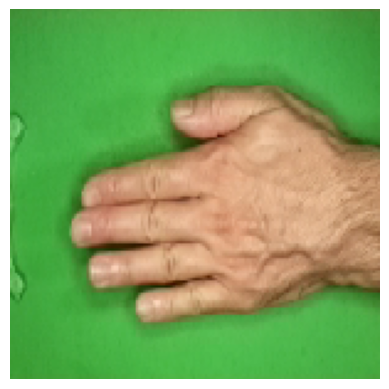

1/1 [==============================] - 0s 47ms/step
Predicted class: rock


In [48]:
# Fungsi untuk melakukan prediksi
def predict_uploaded_image(model, file_path):
    # Memuat dan menampilkan gambar yang diunggah
    img = image.load_img(file_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Memproses gambar untuk prediksi
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Normalisasi nilai pixel ke rentang [0, 1]

    # Melakukan prediksi dengan model
    classes = model.predict(x, batch_size=10)

    # Menentukan hasil prediksi
    class_labels = ['rock', 'paper', 'scissors']
    predicted_label = class_labels[np.argmax(classes)]

    print(f'Predicted class: {predicted_label}')

# Mengunggah gambar untuk diprediksi
uploaded = files.upload()

for fn in uploaded.keys():
    predict_uploaded_image(model, fn)
